<a href="https://colab.research.google.com/github/Aruna-Jayarajan/Satelite_Network/blob/main/GNN_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sys
import os

# Add `src/` directory to module search path
sys.path.append(os.path.join(os.getcwd(), 'src'))

# Now import project modules
from dataloader import SatelliteDataset, NUM_GATEWAYS
from model import Stage2GNN
from train import train_model_with_mse
from utils import plot_metrics


In [2]:
from torch_geometric.loader import DataLoader as PyGDataLoader

DATA_FOLDER = r"C:\Users\aruna\Desktop\MS Thesis\Real Data\Final folder real data"
file_list = sorted([os.path.join(DATA_FOLDER, f) for f in os.listdir(DATA_FOLDER) if f.endswith('.csv')])[:10]

train_size = int(0.8 * len(file_list))
train_files, val_files = file_list[:train_size], file_list[train_size:]

train_dataset = SatelliteDataset(train_files)
val_dataset = SatelliteDataset(val_files)

train_loader = PyGDataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = PyGDataLoader(val_dataset, batch_size=16, shuffle=False)

print(f"Loaded {len(train_files)} training files and {len(val_files)} validation files.")


Loaded 8 training files and 2 validation files.


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from tensorflow.keras.models import load_model

STAGE1_MODEL_PATH = 'stage_1_visible_model.h5'
stage1_model = load_model(STAGE1_MODEL_PATH)

input_dim = 3 + NUM_GATEWAYS * 3
gnn_model = Stage2GNN(input_dim=input_dim, sat_feature_dim=111, neighbor_feature_dim=NUM_GATEWAYS,
                      hidden_dim=256, output_dim=NUM_GATEWAYS)

optimizer_gnn = optim.Adam(gnn_model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cpu


In [5]:
results = train_model_with_mse(
    gnn_model=gnn_model,
    stage1_model=stage1_model,
    train_loader=train_loader,
    val_loader=val_loader,
    loss_fn=loss_fn,
    optimizer_gnn=optimizer_gnn,
    num_epochs=10,
    rounds=15
)

(train_losses, val_losses,
 train_top1_acc, train_top3_acc, train_top5_acc,
 val_top1_acc, val_top3_acc, val_top5_acc) = results


Epoch 2, Train Loss: 3.9762, Val Loss: 3.9379
Epoch 4, Train Loss: 3.9038, Val Loss: 3.8616
Epoch 6, Train Loss: 3.7856, Val Loss: 3.7279
Epoch 8, Train Loss: 3.5929, Val Loss: 3.5139
Epoch 10, Train Loss: 3.3116, Val Loss: 3.2219


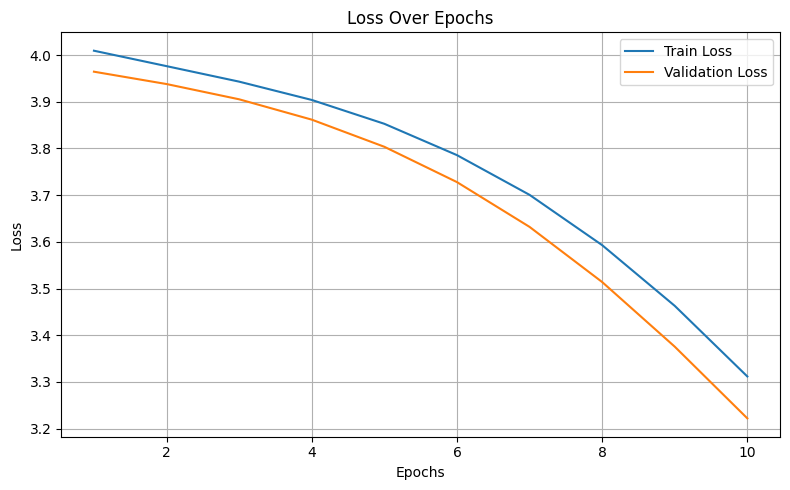

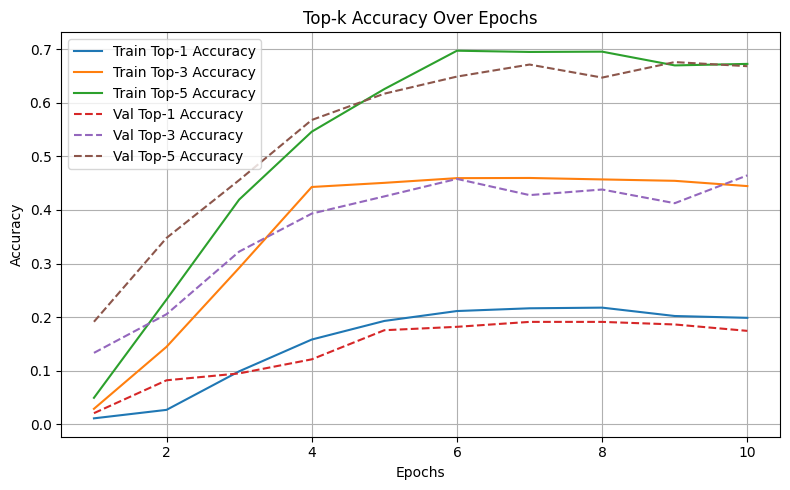

Model saved.


In [6]:
plot_metrics(train_losses, val_losses,
             train_top1_acc, train_top3_acc, train_top5_acc,
             val_top1_acc, val_top3_acc, val_top5_acc)

# Save model
torch.save(gnn_model.state_dict(), 'stage2_loop_gnn_model.pth')
print("Model saved.")


Testing

In [10]:
import os
import torch
import numpy as np
import pandas as pd
from torch_geometric.data import DataLoader
from tensorflow.keras.models import load_model

from dataloader import prepare_input_for_gnn
from utils import top_k_accuracy
from model import Stage2GNN

# Paths
DATA_FOLDER = r"C:\Users\aruna\Desktop\MS Thesis\Real Data\Final folder real data"
STAGE1_MODEL_PATH = 'stage_1_visible_model.h5'
STAGE2_MODEL_PATH = 'stage2_loop_gnn_model.pth'  # Trained with MSE

# Load models
stage1_model = load_model(STAGE1_MODEL_PATH)

# Define GNN model (match architecture from training)
input_dim = 3 + NUM_GATEWAYS * 3
gnn_model = Stage2GNN(input_dim=input_dim, sat_feature_dim=111,
                      neighbor_feature_dim=NUM_GATEWAYS, hidden_dim=256, output_dim=NUM_GATEWAYS)
gnn_model.load_state_dict(torch.load(STAGE2_MODEL_PATH))
gnn_model.eval()

# Prepare test files (files 100 to 105)
file_list = sorted([os.path.join(DATA_FOLDER, f) for f in os.listdir(DATA_FOLDER) if f.endswith('.csv')])
test_files = file_list[100:105]

# Build PyG Data objects
test_graphs = [build_graph_from_file(f) for f in test_files if build_graph_from_file(f) is not None]
test_loader = DataLoader(test_graphs, batch_size=1, shuffle=False)

# Evaluate
total_top1, total_top3, total_top5, total_samples = 0, 0, 0, 0
predictions = []

with torch.no_grad():
    for data in test_loader:
        input_features = data.x[:, :57].cpu().numpy()
        stage1_preds = stage1_model.predict(input_features, verbose=0)
        top3_model1 = np.argsort(stage1_preds, axis=1)[:, -3:]

        # Convert to binary
        binary_preds_model1 = np.zeros_like(stage1_preds)
        for i, idx in enumerate(top3_model1):
            binary_preds_model1[i, idx] = 1

        gnn_input = prepare_input_for_gnn(data, torch.tensor(binary_preds_model1, dtype=torch.float))
        preds = gnn_model(gnn_input.x, gnn_input.edge_index)

        # Accuracy calculation
        total_top1 += top_k_accuracy(preds, data.y, k=1)
        total_top3 += top_k_accuracy(preds, data.y, k=3)
        total_top5 += top_k_accuracy(preds, data.y, k=5)
        total_samples += 1

        # Optional: store for inspection
        top1_pred = torch.topk(preds, k=1, dim=1).indices.squeeze().tolist()
        for i in range(len(data.y)):
            predictions.append([data.y[i].item(), top1_pred[i]])

# Print final accuracy
print("\n===== FINAL TEST ACCURACY (5 FILES) =====")
print(f"Top-1 Accuracy: {total_top1 / total_samples:.4f}")
print(f"Top-3 Accuracy: {total_top3 / total_samples:.4f}")
print(f"Top-5 Accuracy: {total_top5 / total_samples:.4f}")

# Optional: Save predictions
results_df = pd.DataFrame(predictions, columns=["Ground Truth", "Top-1 Prediction"])
results_df.to_csv("test_results_mse.csv", index=False)
print("\nSaved predictions to test_results_mse.csv")


ImportError: cannot import name 'top_k_accuracy' from 'utils' (c:\Users\aruna\Satelite_Network\src\utils.py)